<a href="https://colab.research.google.com/github/DiegoLeon96/Neural-Speech-Dereverberation/blob/main/models/MLP_dereverberation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install soundfile
!pip install librosa==0.8.0
!pip install scipy==1.5.2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import librosa
import librosa.display as display
import soundfile as sf
import os
import sys
import torch
import cv2

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import random
from sklearn.preprocessing import StandardScaler


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data

In [ ]:
X_train1 = torch.load('/content/drive/My Drive/data_audio/X_train_n1')
X_train2 = torch.load('/content/drive/My Drive/data_audio/X_train_n2')
X_train3 = torch.load('/content/drive/My Drive/data_audio/X_train_n3')
X_train4 = torch.load('/content/drive/My Drive/data_audio/X_train_n4')
y_train1 = torch.load('/content/drive/My Drive/data_audio/y_train_n1')
y_train2 = torch.load('/content/drive/My Drive/data_audio/y_train_n2')
y_train3 = torch.load('/content/drive/My Drive/data_audio/y_train_n3')
y_train4 = torch.load('/content/drive/My Drive/data_audio/y_train_n4')

In [ ]:
X = torch.cat((X_train1, X_train2, X_train3, X_train4))
y = torch.cat((y_train1, y_train2, y_train3, y_train4))

In [ ]:
print(X.shape)
print(y.shape)

torch.Size([20000, 1, 128, 340])
torch.Size([20000, 1, 128, 340])


# Model

In [ ]:
class DNN(nn.Module):
    """
    Adaptive implementation of MLP for speech dereverberation
    """

    def __init__(self,neural_layers,act_fun):
        super(DNN, self).__init__()
        self.layers = nn.Sequential()
        
        if len(neural_layers) < 2:
          print('len(neural_layes) must be higher than 2')
          return
        for i in range(len(neural_layers)-1):
          self.layers.add_module('layer_{}'.format(i+1),
                                 nn.Linear(neural_layers[i],
                                           neural_layers[i+1])
                                 )
          self.layers.add_module('act_fun_{}'.format(i+1),
                                 act_fun[i])
        
    def forward(self, x):
        x = self.layers(x)
        return x

# Dataset

In [ ]:
class reverb_dataset(Dataset):
  """
  Reverberation dataset
  """

  def __init__(self, X, y):
    """
    X: (# examples, 1, 128, 340) tensor containing reverberant spectrograms
    y: (# examples, 1, 128, 340) tensor containing target spectrograms
    """
    self.X = X
    self.y = y
  
  def __len__(self):
    return self.X.shape[0]
  
  def __getitem__(self, index):
    return self.X[index], self.y[index]

In [ ]:
total_dataset = reverb_dataset(X, y)
length_train = int(len(total_dataset)*0.85)
length_val = len(total_dataset) - length_train
lengths = [length_train, length_val]
dataset_train, dataset_val = random_split(total_dataset, lengths)

In [ ]:
print(len(dataset_train))
print(len(dataset_val))

17000
3000


In [ ]:
def split_specgram(example, clean_example, frames = 11):
  """
  Split specgram in groups of frames, the purpose is prepare data for the LSTM model input

  example: reverberant spectrogram
  clean_example: clean or target spectrogram

  return data input to the LSTM model and targets
  """

  clean_spec = clean_example[0, :, :]
  rev_spec = example[0, :, :]

  n, m = clean_spec.shape

  targets = torch.zeros((m-frames, n))
  data = torch.zeros((m-frames, n*frames))

  for i in range(m-frames):
    targets[i, :] = clean_spec[:, i]
    data[i, :] = torch.reshape(rev_spec[:, i:i+frames], (1, -1))[0, :]
  return data, targets


def split_realdata(example, frames = 11):
  """
  Split 1 specgram in groups of frames, the purpose is prepare data for the LSTM model input

  example: reverberant ''real'' (not simulated) spectrogram

  return data input to the LSTM model 
  """

  rev_spec = example[0, :, :]
  n, m = rev_spec.shape
  data = torch.zeros((m-frames, n*frames))
  for i in range(m-frames):
    data[i, :] = torch.reshape(rev_spec[:, i:i+frames], (1, -1))[0, :]
  return data

def prepare_data(X, y, display = False):
  """
  Use split_specgram to split all specgrams
  X: tensor containing reverberant spectrograms
  y: tensor containing tensor spectrograms
  """

  data0, target0 = split_specgram(X[0, :, :, :], y[0, :, :, :])

  total_data = data0.cuda()
  targets = target0.cuda()
  
  for i in range(1, X.shape[0]):
    
    if display: 
      print("Specgram n°" + str(i)) 
      
    data_i, target_i = split_specgram(X[i, :, :, :], y[i, :, :, :])
    
    total_data = torch.cat((total_data, data_i.cuda()), 0)
    targets = torch.cat((targets, target_i.cuda()), 0)

  return  total_data, targets

def generate_spec(audio_sequence, rate, n_fft=2048, hop_length=512):
    """
    generate spectrogram using Librosa

    audio_sequence: list containing waveform
    rate: sampling rate
    n_fft, hop_length: stft parameters

    return log power spectra
    """
    S = librosa.feature.melspectrogram(audio_sequence, sr=rate, n_fft=n_fft, hop_length=hop_length, n_mels=128, fmin=20, fmax=8300)
    log_spectra = librosa.power_to_db(S, ref=np.mean, top_db=80)
    return log_spectra

def graph_spec(spec, rate = 16000, title = False):
  """
  plot spectrogram 
  spec: spectrogram generated using Librosa
  rate: sampling rate
  """
  plt.figure()
  display.specshow(spec, sr=rate, y_axis='mel', x_axis='time')
  plt.colorbar(format='%+2.0f dB')
  if (title):
    plt.title('Log-Power spectrogram')
  plt.tight_layout()

def reconstruct_wave(spec, rate = 16000):
  """
  Reconstruct waveform
  spec: spectrogram generated using Librosa
  rate: sampling rate
  """
  power = librosa.db_to_power(spec, ref = 5.0)
  audio = librosa.feature.inverse.mel_to_audio(power, sr = rate, n_fft = 2048, hop_length = 512)
  return audio

def plot_time_wave(audio, rate = 16000):
  """
  plot waveform given speech audio
  audio: array containing waveform
  rate: sampling rate
  
  """
  time = [0]
  for i in range(1, len(audio)):
    time.append(time[i-1] + 1/rate)

  plt.figure()
  plt.plot(time, audio)
  plt.xlabel("Time (secs)")
  plt.ylabel("Power")



def normalize(spec, eps=1e-6):
  """
  Normalize spectrogram with zero mean and unitary variance
  spec: spectrogram generated using Librosa
  """
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  return spec_norm, (mean, std)


In [ ]:
def trainer_sec(model, train_loader, val_loader, checkpoints, nEpochs = 100, lr = 1e-3):
  """
  Train model

  model: MLP based neural network
  train_loader: dataloader containing train examples
  val_loader: dataloader containing validation examples
  checkpoints: list of directories to save the model, train loss and Val loss respectively
  """
  criterion = nn.MSELoss()
  beta1 = 0.5
  beta2 = 0.999
  lr_decay = 0.97
  decay_rate = 2

  optimizer = torch.optim.Adam(model.parameters(), lr, (beta1, beta2))

  train_loss = []
  val_loss = []
  
  model.train()
  for epoch in range(nEpochs):
    temp_train_loss = 0.0
    corrects_train = 0
    for i, (rev_data, clean_data) in enumerate(train_loader):
      rev_data = rev_data.cuda()
      clean_data = clean_data.cuda()
      rev_data, clean_data = prepare_data(rev_data, clean_data)

      optimizer.zero_grad()
      output = model(rev_data)
      loss_train = criterion(output, clean_data)
      loss_train.backward()
      optimizer.step()

      temp_train_loss += loss_train.item()

    temp_val_loss = 0.0    
    #Validacion
    model.eval()
    with torch.no_grad():
      for i, (rev_data, clean_data) in enumerate(val_loader):
        rev_data = rev_data.cuda()
        clean_data = clean_data.cuda()

        rev_data, clean_data = prepare_data(rev_data, clean_data)
        output = model(rev_data)
        loss_val = criterion(output, clean_data)
        temp_val_loss += loss_val.item()

    train_loss.append(temp_train_loss)
    val_loss.append(temp_val_loss)

    print('Epoch : {} || Train Loss: {:.3f} || Val Loss: {:.3f}'\
         .format(epoch+1, loss_train.item(), loss_val.item()))
    model.train()
    
    if ((epoch+1)%5 == 0):
      torch.save(model, checkpoints[0])
      torch.save(train_loss, checkpoints[1])
      torch.save(val_loss, checkpoints[2])
      print("saved models")

    if (epoch % decay_rate == 1):
       optimizer.param_groups[0]['lr'] *= lr_decay

  return train_loss, val_loss

In [ ]:
train_loader = DataLoader(dataset_train, batch_size = 16, shuffle = True, num_workers = 4, pin_memory = True)
val_loader = DataLoader(dataset_val, batch_size = 16, shuffle = True, num_workers = 4, pin_memory = True)

In [ ]:
net = DNN([128*11, 1600, 1600, 1600, 128],[nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.Identity()])
net = net.cuda()

checkpoints = ['/content/drive/My Drive/data_audio/model_dnn1', '/content/drive/My Drive/data_audio/train_loss_dnn1', 
               '/content/drive/My Drive/data_audio/val_loss_dnn1']

train_loss, val_loss = trainer_sec(net, train_loader, val_loader, checkpoints, lr=2e-4, nEpochs=50)

Epoch : 1 || Train Loss: 0.197 || Val Loss: 0.186
Epoch : 2 || Train Loss: 0.140 || Val Loss: 0.132
Epoch : 3 || Train Loss: 0.126 || Val Loss: 0.115
Epoch : 4 || Train Loss: 0.117 || Val Loss: 0.115
Epoch : 5 || Train Loss: 0.106 || Val Loss: 0.091
saved models
Epoch : 6 || Train Loss: 0.110 || Val Loss: 0.116
Epoch : 7 || Train Loss: 0.099 || Val Loss: 0.105
Epoch : 8 || Train Loss: 0.104 || Val Loss: 0.111
Epoch : 9 || Train Loss: 0.105 || Val Loss: 0.099
Epoch : 10 || Train Loss: 0.100 || Val Loss: 0.086
saved models
Epoch : 11 || Train Loss: 0.090 || Val Loss: 0.107
Epoch : 12 || Train Loss: 0.089 || Val Loss: 0.117
Epoch : 13 || Train Loss: 0.097 || Val Loss: 0.096
Epoch : 14 || Train Loss: 0.081 || Val Loss: 0.096
Epoch : 15 || Train Loss: 0.084 || Val Loss: 0.092
saved models
Epoch : 16 || Train Loss: 0.089 || Val Loss: 0.096
Epoch : 17 || Train Loss: 0.090 || Val Loss: 0.085
Epoch : 18 || Train Loss: 0.097 || Val Loss: 0.086
Epoch : 19 || Train Loss: 0.088 || Val Loss: 0.094
E

In [ ]:
net = DNN([128*11, 1600, 1600, 1600, 128],[nn.ReLU(), nn.ReLU(), nn.ReLU(), nn.Identity()])
net = net.cuda()

checkpoints = ['/content/drive/My Drive/data_audio/model_dnn2', '/content/drive/My Drive/data_audio/train_loss_dnn2', 
               '/content/drive/My Drive/data_audio/val_loss_dnn2']

train_loss, val_loss = trainer_sec(net, train_loader, val_loader, checkpoints, lr=2e-4, nEpochs=50)

Epoch : 1 || Train Loss: 0.128 || Val Loss: 0.140
Epoch : 2 || Train Loss: 0.122 || Val Loss: 0.129
Epoch : 3 || Train Loss: 0.129 || Val Loss: 0.120
Epoch : 4 || Train Loss: 0.110 || Val Loss: 0.115
Epoch : 5 || Train Loss: 0.108 || Val Loss: 0.105
saved models
Epoch : 6 || Train Loss: 0.109 || Val Loss: 0.107
Epoch : 7 || Train Loss: 0.106 || Val Loss: 0.111
Epoch : 8 || Train Loss: 0.089 || Val Loss: 0.099
Epoch : 9 || Train Loss: 0.098 || Val Loss: 0.100
Epoch : 10 || Train Loss: 0.114 || Val Loss: 0.092
saved models
Epoch : 11 || Train Loss: 0.087 || Val Loss: 0.095
Epoch : 12 || Train Loss: 0.091 || Val Loss: 0.115
Epoch : 13 || Train Loss: 0.092 || Val Loss: 0.087
Epoch : 14 || Train Loss: 0.084 || Val Loss: 0.109
Epoch : 15 || Train Loss: 0.087 || Val Loss: 0.100
saved models
Epoch : 16 || Train Loss: 0.086 || Val Loss: 0.108
Epoch : 17 || Train Loss: 0.092 || Val Loss: 0.086
Epoch : 18 || Train Loss: 0.082 || Val Loss: 0.100
Epoch : 19 || Train Loss: 0.074 || Val Loss: 0.089
E

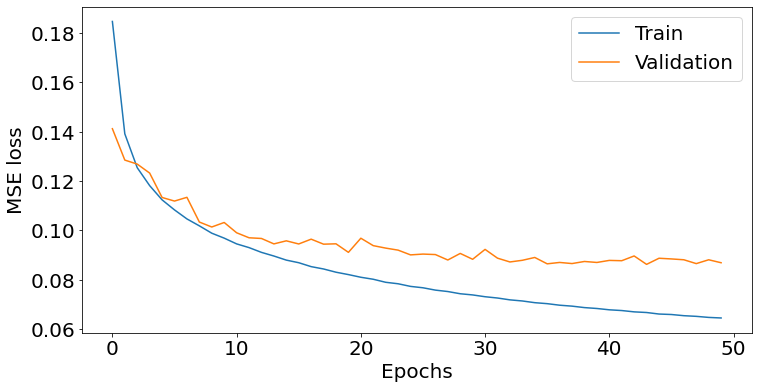

In [ ]:
train_loss = torch.load('/content/drive/My Drive/data_audio/train_loss_dnn2')
val_loss = torch.load('/content/drive/My Drive/data_audio/val_loss_dnn2')

train_loss = (16/17000)*np.array(train_loss)
val_loss = (16/3000)*np.array(val_loss)

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
matplotlib.rcParams.update({'font.size': 20})
plt.figure(figsize = (12, 6))
plt.plot(train_loss, label = 'Train')
plt.plot(val_loss, label = 'Validation')
plt.xlabel('Epochs')
plt.ylabel('MSE loss')
plt.legend()

# Qualitative evaluation

In [ ]:
def evaluate_qualitative(net, audio_dirs, num_example, speech_rate=16000):
  """
  net: MLP model on CPU
  audio_dirs: list of directories containing reverberant spectrograms, clean spectrograms,
              reverberant waveforms and clean waveforms respectively
  num_example: example number in data
  speech_rate: sampling rate of speech data  
  """
  matplotlib.rc('xtick', labelsize=15)  
  matplotlib.rc('ytick', labelsize=15)
  matplotlib.rcParams.update({'font.size': 15})

  X_test = torch.load(audio_dirs[0])
  y_test = torch.load(audio_dirs[1])
  waves = torch.load(audio_dirs[2])
  waves_target = torch.load(audio_dirs[3])

  original_spec = generate_spec(waves[num_example], speech_rate)
  clean_spec = generate_spec(waves_target[num_example], speech_rate)
  original_size = original_spec.shape

  net.eval()

  example_rev = torch.clone(X_test[num_example, :, :, :])
  target = torch.clone(y_test[num_example, :, :, :])

  ex_rev_norm, ex_data_norm = normalize(example_rev[0, :, :].numpy())
  target_norm, target_data_norm = normalize(target[0, :, :].numpy())

  example_rev[0, :, :] = torch.tensor(ex_rev_norm)
  target[0, :, :] = torch.tensor(target_norm)

  spec_test0, targets0 = split_specgram(example_rev, target)
  spec_test_response = net(spec_test0).cpu().detach().numpy().T

  spec_test_response = spec_test_response*(ex_data_norm[1]+1e-6) + ex_data_norm[0]
  spec_test_response = cv2.resize(spec_test_response, dsize = (original_size[1], original_size[0]), interpolation = cv2.INTER_LANCZOS4)

  graph_spec(clean_spec)
  graph_spec(original_spec)
  graph_spec(spec_test_response)


In [ ]:
net = torch.load('/content/drive/My Drive/data_audio/model_dnn2', map_location=lambda storage, loc: storage)
dir_list = ['/content/drive/My Drive/data_audio/X_test', '/content/drive/My Drive/data_audio/y_test',
            '/content/drive/My Drive/data_audio/waverev', '/content/drive/My Drive/data_audio/wavetarget']

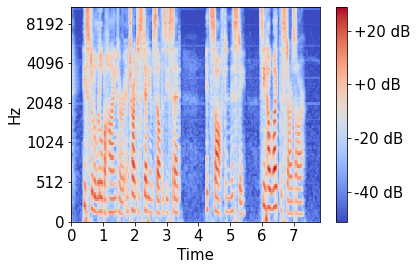

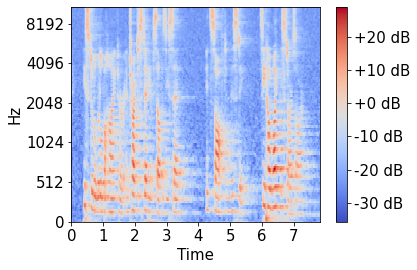

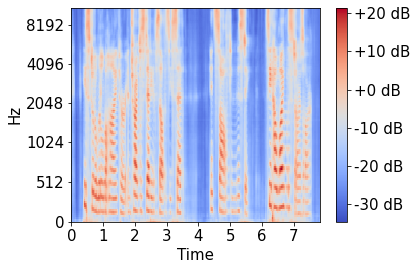

In [ ]:
evaluate_qualitative(net, dir_list, 100)

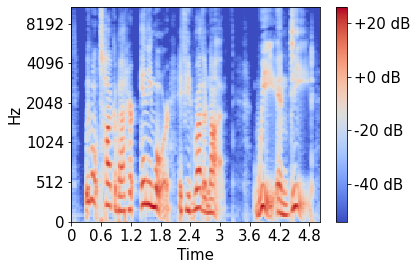

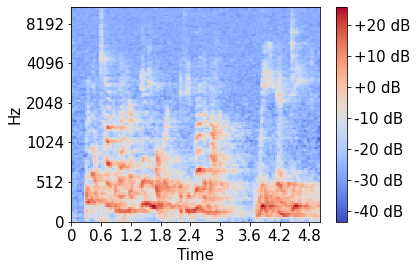

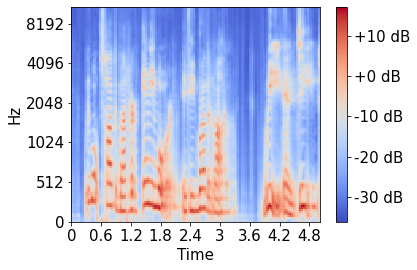

In [ ]:
evaluate_qualitative(net, dir_list, 300)

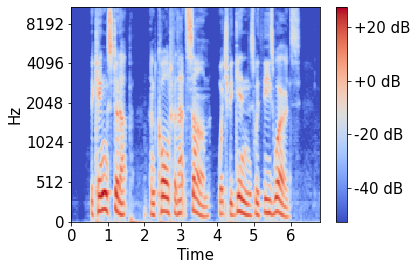

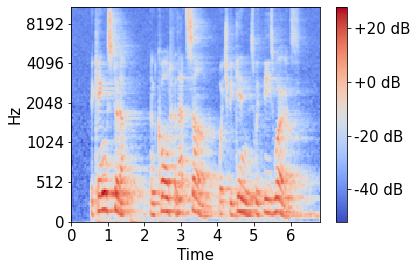

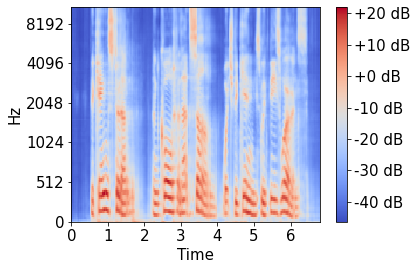

In [ ]:
evaluate_qualitative(net, dir_list, 400)

# Quantitative evaluation

In [ ]:
!pip3 install https://github.com/schmiph2/pysepm/archive/master.zip

     - 2.0MB 1.3MB/s
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     | 71kB 57.1MB/s
     | 276kB 27.5MB/s
     / 65.2MB 46kB/s
     |████████████████████████████████| 163kB 5.2MB/s 
  Created wheel for pysepm: filename=pysepm-0.1-cp36-none-any.whl size=24291 sha256=cc83ca2bcbb006bf1b58f5185521542c4b6651e0d4b2895698e021cdf696ec70
  Stored in directory: /tmp/pip-ephem-wheel-cache-xqgxd_lp/wheels/17/75/23/17712e0da834688ac430e0cf826dd1f7450d0b4873e0269f7c
Successfully built pysepm
  Created wheel for SRMRpy: filename=SRMRpy-1.0-cp36-none-any.whl size=9397 sha256=3d024d6ccfae970186a215515bf10052e95ccb7c8c881390b48d7f547851a1f1
  Stored in directory: /tmp/pip-ephem-wheel-cache-xqgxd_lp/wheels/ef/f1/00/7c2aef84fdfd2c195486371d26b18f72c5bda5fe8442ef4c00
  Created wheel for pystoi: filename=pystoi-0.3.3-py2.py3-none-any.whl size=7781 sha256=68049f7571393513d2533690cd1da27f81632f9b092567d6318c99c83cc2897e
  Stor

In [ ]:
!pip install pystoi
!pip install pypesq
from pysepm import *
from pystoi import stoi
from pypesq import pesq

  Created wheel for pypesq: filename=pypesq-1.2.4-cp36-cp36m-linux_x86_64.whl size=82985 sha256=e3df1af181d7bd3f35628312a09875174d97514ca92d880468e10ad968eb0818
  Stored in directory: /root/.cache/pip/wheels/c9/29/a6/ed19583426cffac50b3e75160f894120a49f9bafa585a2edbe
Successfully built pypesq


In [ ]:
def evaluate(net, dataset, path, path_waves, init_example, end_example, speech_rate = 16000, initial = True, normalize_data = True):
  """
  net: MLP based model to evaluate
  dataset: reverb_dataset object to extract examples
  path: base directory to save results
  path_waves: directory containing reverb waveforms (not recovered from spectrograms)
  init_example: first example in dataset to be considered
  end_example: last exalple in dataset to be considered
  speech_rate: sampling rate of speech audios
  initial: True if is the first time executing, False if is not the first time
           if is False the new results are added to the existing results
  normalize_data: True if the net assumed normalized input 
  """
  
  device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
  print('Current device: ' + str(device))
 
  if (initial):
    reverb_pesq_list = []
    reverb_stoi_list = []
    reverb_llr_list = []
    reverb_cd_list = []
    reverb_fwSNRseg_list = []
    reverb_srmr_list = []

    dereverb_pesq_list = []
    dereverb_stoi_list = []
    dereverb_llr_list = []
    dereverb_cd_list = []
    dereverb_fwSNRseg_list = []
    dereverb_srmr_list = []
  
  else:
    reverb_pesq_list = torch.load(path + 'reverb_pesq_dnn')
    reverb_stoi_list = torch.load(path + 'reverb_stoi_dnn')
    reverb_llr_list = torch.load(path + 'reverb_llr_dnn')
    reverb_cd_list = torch.load(path + 'reverb_cd_dnn')
    reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_dnn')
    reverb_srmr_list = torch.load(path + 'reverb_srmr_dnn')

    dereverb_pesq_list = torch.load(path + 'dereverb_pesq_dnn')
    dereverb_stoi_list = torch.load(path + 'dereverb_stoi_dnn')
    dereverb_llr_list = torch.load(path + 'dereverb_llr_dnn')
    dereverb_cd_list = torch.load(path + 'dereverb_cd_dnn')
    dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_dnn')
    dereverb_srmr_list = torch.load(path + 'dereverb_srmr_dnn')

  waves = torch.load(path_waves)
  net.eval()
  for i in range(init_example, end_example):
    print('Processing specgram n°:' + str(i+1))
    real_spec = generate_spec(waves[i], speech_rate)
    rev_copy, target_copy = dataset.__getitem__(i)
    if (normalize_data):
            
      #normalize
      norm_example, norm_stats_rev = normalize(rev_copy[0, :, :].numpy())
      norm_target, norm_stats_target = normalize(target_copy[0, :, :].numpy())
      
      rev_copy_norm = torch.zeros((rev_copy.shape))
      target_copy_norm = torch.zeros((target_copy.shape))
      
      rev_copy_norm[0, :, :] = torch.tensor(norm_example)
      target_copy_norm[0, :, :] = torch.tensor(norm_target)
       
      spec_test, targets = split_specgram(rev_copy_norm, target_copy_norm)  
      spec_test_response = net(spec_test.to(device)).cpu().detach().numpy().T
      spec_test_response = spec_test_response*(norm_stats_rev[1] + 1e-6) + norm_stats_rev[0] # denormalize (it doesnt use the target)

    else:
      spec_test, targets = split_specgram(rev_copy[0, :, :].numpy(), target_copy[0, :, :].numpy())
      spec_test_response = net(spec_test.to(device)).cpu().detach().numpy().T
    
    recon_spec = cv2.resize(spec_test_response, dsize = (real_spec.shape[1], real_spec.shape[0]), interpolation = cv2.INTER_LANCZOS4)

    original = reconstruct_wave(target_copy[0, :, :].numpy())
    reverb = reconstruct_wave(rev_copy[0, :, :].numpy())
    recon = reconstruct_wave(spec_test_response)
    recon_srmr = reconstruct_wave(recon_spec)

    pesq_metric_rev = pesq(original[0:len(reverb)], reverb, fs = speech_rate)
    stoi_metric_rev = stoi(original[0:len(reverb)], reverb, speech_rate)
    llr_metric_rev = llr(original[0:len(reverb)], reverb, speech_rate)
    cd_metric_rev = cepstrum_distance(original[0:len(reverb)], reverb, speech_rate)
    fwSNRseg_metric_rev = fwSNRseg(original[0:len(reverb)], reverb, speech_rate)
    srmr_metric_rev = srmr(waves[i], speech_rate)

    pesq_metric_recon = pesq(original[0:len(recon)], recon, fs = speech_rate)
    stoi_metric_recon = stoi(original[0:len(recon)], recon, speech_rate)
    llr_metric_recon = llr(original[0:len(recon)], recon, speech_rate)
    cd_metric_recon = cepstrum_distance(original[0:len(recon)], recon, speech_rate)
    fwSNRseg_metric_recon = fwSNRseg(original[0:len(recon)], recon, speech_rate)
    srmr_metric_recon = srmr(recon_srmr, speech_rate)

    reverb_pesq_list.append(pesq_metric_rev)
    reverb_stoi_list.append(stoi_metric_rev)
    reverb_llr_list.append(llr_metric_rev)
    reverb_cd_list.append(cd_metric_rev)
    reverb_fwSNRseg_list.append(fwSNRseg_metric_rev)
    reverb_srmr_list.append(srmr_metric_rev)

    dereverb_pesq_list.append(pesq_metric_recon)
    dereverb_stoi_list.append(stoi_metric_recon)
    dereverb_llr_list.append(llr_metric_recon)
    dereverb_cd_list.append(cd_metric_recon)
    dereverb_fwSNRseg_list.append(fwSNRseg_metric_recon)
    dereverb_srmr_list.append(srmr_metric_recon)

    print('PESQ reverberated signal: {:.3f} || PESQ dereverberated signal: {:.3f}'.format(pesq_metric_rev, pesq_metric_recon))
    print('STOI reverberated signal: {:.3f} || STOI dereverberated signal: {:.3f}'.format(stoi_metric_rev, stoi_metric_recon))
    print('LLR reverberated signal: {:.3f} || LLR dereverberated signal: {:.3f}'.format(llr_metric_rev, llr_metric_recon))
    print('CD reverberated signal: {:.3f} || CD dereverberated signal: {:.3f}'.format(cd_metric_rev, cd_metric_recon))
    print('fwSNRseg reverberated signal: {:.3f} || fwSNRseg dereverberated signal: {:.3f}'.format(fwSNRseg_metric_rev, fwSNRseg_metric_recon))
    print('SRMR reverberated signal: {:.3f} || SRMR dereverberated signal: {:.3f}'.format(srmr_metric_rev, srmr_metric_recon))
    print('\n')

    if ((i+1)%10 == 0):
      torch.save(reverb_pesq_list, path + 'reverb_pesq_dnn')
      torch.save(reverb_stoi_list, path + 'reverb_stoi_dnn')
      torch.save(reverb_llr_list, path + 'reverb_llr_dnn')
      torch.save(reverb_cd_list, path + 'reverb_cd_dnn')
      torch.save(reverb_fwSNRseg_list, path + 'reverb_fwSNRseg_dnn')
      torch.save(reverb_srmr_list, path + 'reverb_srmr_dnn')

      torch.save(dereverb_pesq_list, path + 'dereverb_pesq_dnn')
      torch.save(dereverb_stoi_list, path + 'dereverb_stoi_dnn')
      torch.save(dereverb_llr_list, path + 'dereverb_llr_dnn')
      torch.save(dereverb_cd_list, path + 'dereverb_cd_dnn')
      torch.save(dereverb_fwSNRseg_list, path + 'dereverb_fwSNRseg_dnn')
      torch.save(dereverb_srmr_list, path + 'dereverb_srmr_dnn')
      
      print('Saved')

## Room Simulated 1

In [ ]:
#net = torch.load('/content/drive/My Drive/data_audio/model_dnn2')
model_dnn = torch.load('/content/drive/My Drive/data_audio/model_dnn2', map_location=lambda storage, loc: storage)
X_test = torch.load('/content/drive/My Drive/data_audio/X_test')
y_test = torch.load('/content/drive/My Drive/data_audio/y_test')
path = '/content/drive/My Drive/metrics_audio/room1/'
path_waves = '/content/drive/My Drive/data_audio/waverev'

dataset = reverb_dataset(X_test, y_test)
evaluate(model_dnn, dataset, path, path_waves, 0, 500, initial = True, normalize_data = True)

Current device: cpu
Processing specgram n°:1
PESQ reverberated signal: 2.146 || PESQ dereverberated signal: 2.105
STOI reverberated signal: 0.804 || STOI dereverberated signal: 0.795
LLR reverberated signal: 0.475 || LLR dereverberated signal: 0.586
CD reverberated signal: 4.041 || CD dereverberated signal: 4.124
fwSNRseg reverberated signal: 8.462 || fwSNRseg dereverberated signal: 8.299
SRMR reverberated signal: 2.961 || SRMR dereverberated signal: 2.838


Processing specgram n°:2
PESQ reverberated signal: 2.070 || PESQ dereverberated signal: 2.150
STOI reverberated signal: 0.800 || STOI dereverberated signal: 0.818
LLR reverberated signal: 0.529 || LLR dereverberated signal: 0.619
CD reverberated signal: 4.335 || CD dereverberated signal: 4.262
fwSNRseg reverberated signal: 7.607 || fwSNRseg dereverberated signal: 8.295
SRMR reverberated signal: 3.543 || SRMR dereverberated signal: 2.866


Processing specgram n°:3
PESQ reverberated signal: 2.030 || PESQ dereverberated signal: 1.929


In [ ]:
path = '/content/drive/My Drive/metrics_audio/room1/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_dnn')
reverb_stoi_list = torch.load(path + 'reverb_stoi_dnn')
reverb_llr_list = torch.load(path + 'reverb_llr_dnn')
reverb_cd_list = torch.load(path + 'reverb_cd_dnn')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_dnn')
reverb_srmr_list = torch.load(path + 'reverb_srmr_dnn')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_dnn')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_dnn')
dereverb_llr_list = torch.load(path + 'dereverb_llr_dnn')
dereverb_cd_list = torch.load(path + 'dereverb_cd_dnn')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_dnn')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_dnn')

print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 1.99
STOI: 0.58
LLR: 0.77
CD: 5.24
fwSNRseg: 7.05
SRMR: 3.16

Dereverberated signal:
PESQ: 1.84
STOI: 0.59
LLR: 0.85
CD: 4.97
fwSNRseg: 6.56
SRMR: 2.72


## Room Simulated 2

In [ ]:
#net = torch.load('/content/drive/My Drive/data_audio/model_dnn2')
model_dnn = torch.load('/content/drive/My Drive/data_audio/model_dnn2', map_location=lambda storage, loc: storage)
X_test = torch.load('/content/drive/My Drive/data_audio/X_test_2')
y_test = torch.load('/content/drive/My Drive/data_audio/y_test_2')
path = '/content/drive/My Drive/metrics_audio/room2/'
path_waves = '/content/drive/My Drive/data_audio/waverev_2'

dataset = reverb_dataset(X_test, y_test)
evaluate(model_dnn, dataset, path, path_waves, 0, 500, initial = True, normalize_data = True)

Current device: cpu
Processing specgram n°:1
PESQ reverberated signal: 2.076 || PESQ dereverberated signal: 1.787
STOI reverberated signal: 0.671 || STOI dereverberated signal: 0.659
LLR reverberated signal: 1.263 || LLR dereverberated signal: 1.321
CD reverberated signal: 6.807 || CD dereverberated signal: 6.600
fwSNRseg reverberated signal: 6.580 || fwSNRseg dereverberated signal: 5.261
SRMR reverberated signal: 2.991 || SRMR dereverberated signal: 1.411


Processing specgram n°:2
PESQ reverberated signal: 2.142 || PESQ dereverberated signal: 1.805
STOI reverberated signal: 0.708 || STOI dereverberated signal: 0.720
LLR reverberated signal: 1.267 || LLR dereverberated signal: 1.265
CD reverberated signal: 6.540 || CD dereverberated signal: 6.429
fwSNRseg reverberated signal: 6.218 || fwSNRseg dereverberated signal: 4.889
SRMR reverberated signal: 2.799 || SRMR dereverberated signal: 1.362


Processing specgram n°:3
PESQ reverberated signal: 2.052 || PESQ dereverberated signal: 1.805


In [ ]:
#net = torch.load('/content/drive/My Drive/data_audio/model_dnn2')
model_dnn = torch.load('/content/drive/My Drive/data_audio/model_dnn2', map_location=lambda storage, loc: storage)
X_test = torch.load('/content/drive/My Drive/data_audio/X_test_2')
y_test = torch.load('/content/drive/My Drive/data_audio/y_test_2')
path = '/content/drive/My Drive/metrics_audio/room2/'
path_waves = '/content/drive/My Drive/data_audio/waverev_2'

dataset = reverb_dataset(X_test, y_test)
evaluate(model_dnn, dataset, path, path_waves, 310, 500, initial = False, normalize_data = True)

Current device: cpu
Processing specgram n°:311
PESQ reverberated signal: 2.038 || PESQ dereverberated signal: 1.483
STOI reverberated signal: 0.559 || STOI dereverberated signal: 0.577
LLR reverberated signal: 0.936 || LLR dereverberated signal: 1.130
CD reverberated signal: 5.894 || CD dereverberated signal: 5.935
fwSNRseg reverberated signal: 6.154 || fwSNRseg dereverberated signal: 4.979
SRMR reverberated signal: 4.089 || SRMR dereverberated signal: 2.494


Processing specgram n°:312
PESQ reverberated signal: 1.903 || PESQ dereverberated signal: 1.505
STOI reverberated signal: 0.542 || STOI dereverberated signal: 0.543
LLR reverberated signal: 1.068 || LLR dereverberated signal: 1.254
CD reverberated signal: 6.227 || CD dereverberated signal: 6.257
fwSNRseg reverberated signal: 6.479 || fwSNRseg dereverberated signal: 5.079
SRMR reverberated signal: 6.112 || SRMR dereverberated signal: 3.319


Processing specgram n°:313
PESQ reverberated signal: 2.118 || PESQ dereverberated signal: 

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room2/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_dnn')
reverb_stoi_list = torch.load(path + 'reverb_stoi_dnn')
reverb_llr_list = torch.load(path + 'reverb_llr_dnn')
reverb_cd_list = torch.load(path + 'reverb_cd_dnn')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_dnn')
reverb_srmr_list = torch.load(path + 'reverb_srmr_dnn')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_dnn')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_dnn')
dereverb_llr_list = torch.load(path + 'dereverb_llr_dnn')
dereverb_cd_list = torch.load(path + 'dereverb_cd_dnn')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_dnn')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_dnn')

print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 2.10
STOI: 0.49
LLR: 0.88
CD: 5.39
fwSNRseg: 6.93
SRMR: 4.49

Dereverberated signal:
PESQ: 1.80
STOI: 0.51
LLR: 1.04
CD: 5.57
fwSNRseg: 5.86
SRMR: 2.45


## Room Simulated 3

In [ ]:
#net = torch.load('/content/drive/My Drive/data_audio/model_dnn2')
model_dnn = torch.load('/content/drive/My Drive/data_audio/model_dnn2', map_location=lambda storage, loc: storage)
X_test = torch.load('/content/drive/My Drive/data_audio/X_test_3')
y_test = torch.load('/content/drive/My Drive/data_audio/y_test_3')
path = '/content/drive/My Drive/metrics_audio/room3/'
path_waves = '/content/drive/My Drive/data_audio/waverev_3'

dataset = reverb_dataset(X_test, y_test)
evaluate(model_dnn, dataset, path, path_waves, 0, 500, initial = True, normalize_data = True)

Current device: cpu
Processing specgram n°:1
PESQ reverberated signal: 2.354 || PESQ dereverberated signal: 2.074
STOI reverberated signal: 0.854 || STOI dereverberated signal: 0.812
LLR reverberated signal: 1.129 || LLR dereverberated signal: 1.157
CD reverberated signal: 6.402 || CD dereverberated signal: 6.131
fwSNRseg reverberated signal: 8.578 || fwSNRseg dereverberated signal: 6.531
SRMR reverberated signal: 3.481 || SRMR dereverberated signal: 1.894


Processing specgram n°:2
PESQ reverberated signal: 2.452 || PESQ dereverberated signal: 1.977
STOI reverberated signal: 0.893 || STOI dereverberated signal: 0.839
LLR reverberated signal: 1.113 || LLR dereverberated signal: 1.193
CD reverberated signal: 6.117 || CD dereverberated signal: 6.118
fwSNRseg reverberated signal: 7.831 || fwSNRseg dereverberated signal: 5.727
SRMR reverberated signal: 3.663 || SRMR dereverberated signal: 1.702


Processing specgram n°:3
PESQ reverberated signal: 2.290 || PESQ dereverberated signal: 2.052


In [ ]:
#net = torch.load('/content/drive/My Drive/data_audio/model_dnn2')
model_dnn = torch.load('/content/drive/My Drive/data_audio/model_dnn2', map_location=lambda storage, loc: storage)
X_test = torch.load('/content/drive/My Drive/data_audio/X_test_3')
y_test = torch.load('/content/drive/My Drive/data_audio/y_test_3')
path = '/content/drive/My Drive/metrics_audio/room3/'
path_waves = '/content/drive/My Drive/data_audio/waverev_3'

dataset = reverb_dataset(X_test, y_test)
evaluate(model_dnn, dataset, path, path_waves, 450, 500, initial = False, normalize_data = True)

Current device: cpu
Processing specgram n°:451
PESQ reverberated signal: 2.328 || PESQ dereverberated signal: 1.711
STOI reverberated signal: 0.818 || STOI dereverberated signal: 0.749
LLR reverberated signal: 0.934 || LLR dereverberated signal: 1.234
CD reverberated signal: 5.661 || CD dereverberated signal: 5.830
fwSNRseg reverberated signal: 8.121 || fwSNRseg dereverberated signal: 4.971
SRMR reverberated signal: 3.853 || SRMR dereverberated signal: 2.227


Processing specgram n°:452
PESQ reverberated signal: 2.202 || PESQ dereverberated signal: 1.716
STOI reverberated signal: 0.790 || STOI dereverberated signal: 0.749
LLR reverberated signal: 1.123 || LLR dereverberated signal: 1.328
CD reverberated signal: 6.186 || CD dereverberated signal: 6.383
fwSNRseg reverberated signal: 7.632 || fwSNRseg dereverberated signal: 4.836
SRMR reverberated signal: 3.944 || SRMR dereverberated signal: 2.056


Processing specgram n°:453
PESQ reverberated signal: 2.122 || PESQ dereverberated signal: 

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room3/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_dnn')
reverb_stoi_list = torch.load(path + 'reverb_stoi_dnn')
reverb_llr_list = torch.load(path + 'reverb_llr_dnn')
reverb_cd_list = torch.load(path + 'reverb_cd_dnn')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_dnn')
reverb_srmr_list = torch.load(path + 'reverb_srmr_dnn')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_dnn')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_dnn')
dereverb_llr_list = torch.load(path + 'dereverb_llr_dnn')
dereverb_cd_list = torch.load(path + 'dereverb_cd_dnn')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_dnn')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_dnn')

print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 2.29
STOI: 0.63
LLR: 0.77
CD: 5.03
fwSNRseg: 8.39
SRMR: 5.21

Dereverberated signal:
PESQ: 1.96
STOI: 0.61
LLR: 0.99
CD: 5.38
fwSNRseg: 6.59
SRMR: 2.73


## Room Simulated 4

In [ ]:
#net = torch.load('/content/drive/My Drive/data_audio/model_dnn2')
model_dnn = torch.load('/content/drive/My Drive/data_audio/model_dnn2', map_location=lambda storage, loc: storage)
X_test = torch.load('/content/drive/My Drive/data_audio/X_test_4')
y_test = torch.load('/content/drive/My Drive/data_audio/y_test_4')
path = '/content/drive/My Drive/metrics_audio/room4/'
path_waves = '/content/drive/My Drive/data_audio/waverev_4'

dataset = reverb_dataset(X_test, y_test)
evaluate(model_dnn, dataset, path, path_waves, 0, 250, initial = True, normalize_data = True)

Current device: cpu
Processing specgram n°:1
PESQ reverberated signal: 2.198 || PESQ dereverberated signal: 1.959
STOI reverberated signal: 0.742 || STOI dereverberated signal: 0.731
LLR reverberated signal: 0.468 || LLR dereverberated signal: 0.618
CD reverberated signal: 4.092 || CD dereverberated signal: 4.211
fwSNRseg reverberated signal: 7.379 || fwSNRseg dereverberated signal: 7.020
SRMR reverberated signal: 2.446 || SRMR dereverberated signal: 2.956


Processing specgram n°:2
PESQ reverberated signal: 2.247 || PESQ dereverberated signal: 2.131
STOI reverberated signal: 0.527 || STOI dereverberated signal: 0.563
LLR reverberated signal: 0.498 || LLR dereverberated signal: 0.495
CD reverberated signal: 4.253 || CD dereverberated signal: 3.760
fwSNRseg reverberated signal: 7.337 || fwSNRseg dereverberated signal: 7.687
SRMR reverberated signal: 2.231 || SRMR dereverberated signal: 2.483


Processing specgram n°:3
PESQ reverberated signal: 2.118 || PESQ dereverberated signal: 1.948


In [ ]:
#net = torch.load('/content/drive/My Drive/data_audio/model_dnn2')
model_dnn = torch.load('/content/drive/My Drive/data_audio/model_dnn2', map_location=lambda storage, loc: storage)
X_test = torch.load('/content/drive/My Drive/data_audio/X_test_4')
y_test = torch.load('/content/drive/My Drive/data_audio/y_test_4')
path = '/content/drive/My Drive/metrics_audio/room4/'
path_waves = '/content/drive/My Drive/data_audio/waverev_4'

dataset = reverb_dataset(X_test, y_test)
evaluate(model_dnn, dataset, path, path_waves, 250, 500, initial = False, normalize_data = True)

Current device: cpu
Processing specgram n°:251
PESQ reverberated signal: 1.884 || PESQ dereverberated signal: 1.684
STOI reverberated signal: 0.523 || STOI dereverberated signal: 0.563
LLR reverberated signal: 0.527 || LLR dereverberated signal: 0.522
CD reverberated signal: 4.509 || CD dereverberated signal: 3.796
fwSNRseg reverberated signal: 4.906 || fwSNRseg dereverberated signal: 6.094
SRMR reverberated signal: 2.539 || SRMR dereverberated signal: 3.400


Processing specgram n°:252
PESQ reverberated signal: 2.006 || PESQ dereverberated signal: 1.946
STOI reverberated signal: 0.819 || STOI dereverberated signal: 0.810
LLR reverberated signal: 0.577 || LLR dereverberated signal: 0.585
CD reverberated signal: 4.857 || CD dereverberated signal: 4.294
fwSNRseg reverberated signal: 6.121 || fwSNRseg dereverberated signal: 6.679
SRMR reverberated signal: 3.222 || SRMR dereverberated signal: 3.543


Processing specgram n°:253
PESQ reverberated signal: 1.807 || PESQ dereverberated signal: 

In [ ]:
path = '/content/drive/My Drive/metrics_audio/room4/'
reverb_pesq_list = torch.load(path + 'reverb_pesq_dnn')
reverb_stoi_list = torch.load(path + 'reverb_stoi_dnn')
reverb_llr_list = torch.load(path + 'reverb_llr_dnn')
reverb_cd_list = torch.load(path + 'reverb_cd_dnn')
reverb_fwSNRseg_list = torch.load(path + 'reverb_fwSNRseg_dnn')
reverb_srmr_list = torch.load(path + 'reverb_srmr_dnn')

dereverb_pesq_list = torch.load(path + 'dereverb_pesq_dnn')
dereverb_stoi_list = torch.load(path + 'dereverb_stoi_dnn')
dereverb_llr_list = torch.load(path + 'dereverb_llr_dnn')
dereverb_cd_list = torch.load(path + 'dereverb_cd_dnn')
dereverb_fwSNRseg_list = torch.load(path + 'dereverb_fwSNRseg_dnn')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_dnn')

print('Results: \n')
print('Reverberant signal:')
print('PESQ: {:.2f}'.format(np.mean(reverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(reverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(reverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(reverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(reverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('PESQ: {:.2f}'.format(np.mean(dereverb_pesq_list)))
print('STOI: {:.2f}'.format(np.mean(dereverb_stoi_list)))
print('LLR: {:.2f}'.format(np.mean(dereverb_llr_list)))
print('CD: {:.2f}'.format(np.mean(dereverb_cd_list)))
print('fwSNRseg: {:.2f}'.format(np.mean(dereverb_fwSNRseg_list)))
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
PESQ: 2.04
STOI: 0.59
LLR: 0.57
CD: 4.59
fwSNRseg: 6.96
SRMR: 3.15

Dereverberated signal:
PESQ: 1.97
STOI: 0.61
LLR: 0.62
CD: 4.24
fwSNRseg: 7.22
SRMR: 3.39


In [ ]:
def evaluate_realdata(net, X_test, path, path_waves, init_example, end_example, speech_rate = 16000, initial = True, normalize_data = True):
  """
  net: MLP based model to evaluate
  X_test: tensor containing reverberant spectrograms (real data, not simulated)
  path: base directory to save results
  path_waves: directory containing reverb waveforms (not recovered from spectrograms)
  init_example: first example in dataset to be considered
  end_example: last exalple in dataset to be considered
  speech_rate: sampling rate of speech audios
  initial: True if is the first time executing, False if is not the first time
           if is False the new results are added to the existing results
  normalize_data: True if the net assumed normalized input 
  """

  device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
  print('Current device: ' + str(device))
 
  if (initial):
    reverb_srmr_list = []
    dereverb_srmr_list = []
  
  else:
    reverb_srmr_list = torch.load(path + 'reverb_srmr_dnn')
    dereverb_srmr_list = torch.load(path + 'dereverb_srmr_dnn')

  waves = torch.load(path_waves)
  net.eval()
  for i in range(init_example, end_example):
    print('Processing specgram n°:' + str(i+1))
    real_spec = generate_spec(waves[i], speech_rate)
    rev_copy = X_test[i, :, :, :]
    if (normalize_data):
            
      #normalize
      norm_example, norm_stats_rev = normalize(rev_copy[0, :, :].numpy())      
      rev_copy_norm = torch.zeros((rev_copy.shape))    
      rev_copy_norm[0, :, :] = torch.tensor(norm_example)
  
      spec_test = split_realdata(rev_copy_norm) 
      spec_test_response = net(spec_test.to(device)).cpu().detach().numpy().T
      spec_test_response = spec_test_response*(norm_stats_rev[1] + 1e-6) + norm_stats_rev[0] # denormalize (it doesnt use the target)

    else:
      spec_test = split_realdata(rev_copy[0, :, :].numpy())
      spec_test_response = net(spec_test.to(device)).cpu().detach().numpy().T
    
    recon_spec = cv2.resize(spec_test_response, dsize = (real_spec.shape[1], real_spec.shape[0]), interpolation = cv2.INTER_LANCZOS4)
    recon_srmr = reconstruct_wave(recon_spec)
    
    srmr_metric_rev = srmr(waves[i], speech_rate)
    srmr_metric_recon = srmr(recon_srmr, speech_rate)

    reverb_srmr_list.append(srmr_metric_rev)
    dereverb_srmr_list.append(srmr_metric_recon)

    print('SRMR reverberated signal: {:.3f} || SRMR dereverberated signal: {:.3f}'.format(srmr_metric_rev, srmr_metric_recon))
    print('\n')

    if ((i+1)%10 == 0):

      torch.save(reverb_srmr_list, path + 'reverb_srmr_dnn')
      torch.save(dereverb_srmr_list, path + 'dereverb_srmr_dnn')
      
      print('Saved')

## Real far data

In [ ]:
path = '/content/drive/My Drive/real_data/far_data/'
path_waves = '/content/drive/My Drive/real_data/waves2'
#model_dnn = torch.load('/content/drive/My Drive/data_audio/model_dnn2')
model_dnn = torch.load('/content/drive/My Drive/data_audio/model_dnn2', map_location=lambda storage, loc: storage)
X_test = torch.load('/content/drive/My Drive/real_data/X_test_real2')

evaluate_realdata(model_dnn, X_test, path, path_waves, 0, 500, initial = True, normalize_data=True)

Current device: cpu
Processing specgram n°:1
SRMR reverberated signal: 3.544 || SRMR dereverberated signal: 4.781


Processing specgram n°:2
SRMR reverberated signal: 5.083 || SRMR dereverberated signal: 4.815


Processing specgram n°:3
SRMR reverberated signal: 4.067 || SRMR dereverberated signal: 6.159


Processing specgram n°:4
SRMR reverberated signal: 3.647 || SRMR dereverberated signal: 4.106


Processing specgram n°:5
SRMR reverberated signal: 5.406 || SRMR dereverberated signal: 5.073


Processing specgram n°:6
SRMR reverberated signal: 3.478 || SRMR dereverberated signal: 3.959


Processing specgram n°:7
SRMR reverberated signal: 5.542 || SRMR dereverberated signal: 5.448


Processing specgram n°:8
SRMR reverberated signal: 2.970 || SRMR dereverberated signal: 4.216


Processing specgram n°:9
SRMR reverberated signal: 7.028 || SRMR dereverberated signal: 6.374


Processing specgram n°:10
SRMR reverberated signal: 5.625 || SRMR dereverberated signal: 5.619


Saved
Processing sp

In [ ]:
path = '/content/drive/My Drive/real_data/far_data/'
reverb_srmr_list = torch.load(path + 'reverb_srmr_dnn')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_dnn')

print('Results: \n')
print('Reverberant signal:')
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
SRMR: 4.36

Dereverberated signal:
SRMR: 4.68


# Near real data

In [ ]:
path = '/content/drive/My Drive/real_data/near_data/'
path_waves = '/content/drive/My Drive/real_data/waves1'
#model_dnn = torch.load('/content/drive/My Drive/data_audio/model_dnn2')
model_dnn = torch.load('/content/drive/My Drive/data_audio/model_dnn2', map_location=lambda storage, loc: storage)
X_test = torch.load('/content/drive/My Drive/real_data/X_test_real1')

evaluate_realdata(model_dnn, X_test, path, path_waves, 0, 500, initial = True, normalize_data=True)

Current device: cpu
Processing specgram n°:1
SRMR reverberated signal: 2.644 || SRMR dereverberated signal: 2.886


Processing specgram n°:2
SRMR reverberated signal: 2.455 || SRMR dereverberated signal: 2.899


Processing specgram n°:3
SRMR reverberated signal: 3.125 || SRMR dereverberated signal: 2.860


Processing specgram n°:4
SRMR reverberated signal: 2.727 || SRMR dereverberated signal: 3.902


Processing specgram n°:5
SRMR reverberated signal: 2.833 || SRMR dereverberated signal: 2.768


Processing specgram n°:6
SRMR reverberated signal: 3.089 || SRMR dereverberated signal: 3.691


Processing specgram n°:7
SRMR reverberated signal: 2.542 || SRMR dereverberated signal: 4.185


Processing specgram n°:8
SRMR reverberated signal: 2.694 || SRMR dereverberated signal: 4.475


Processing specgram n°:9
SRMR reverberated signal: 2.502 || SRMR dereverberated signal: 2.870


Processing specgram n°:10
SRMR reverberated signal: 4.001 || SRMR dereverberated signal: 3.674


Saved
Processing sp

In [ ]:
path = '/content/drive/My Drive/real_data/near_data/'
reverb_srmr_list = torch.load(path + 'reverb_srmr_dnn')
dereverb_srmr_list = torch.load(path + 'dereverb_srmr_dnn')

print('Results: \n')
print('Reverberant signal:')
print('SRMR: {:.2f}'.format(np.mean(reverb_srmr_list)))

print('\nDereverberated signal:')
print('SRMR: {:.2f}'.format(np.mean(dereverb_srmr_list)))

Results: 

Reverberant signal:
SRMR: 3.99

Dereverberated signal:
SRMR: 4.13


In [ ]:
example = torch.load('/content/drive/My Drive/metrics_audio/dereverb_pesq_dnn')
example2 = torch.load('/content/drive/My Drive/metrics_audio/reverb_pesq_dnn')

In [ ]:
sf.write('/content/drive/My Drive/audio2/original.wav', original, 16000) 
sf.write('/content/drive/My Drive/audio2/reverb.wav', reverb, 16000) 
sf.write('/content/drive/My Drive/audio2/recon.wav', reconstruction, 16000) 